In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
data = run('ES', ema, output=True)

weights: 
ema_5      0.196511
ema_10     0.154005
ema_20     0.135945
ema_40     0.136583
ema_80     0.155530
ema_160    0.221426

adjustments:
ema_5      9.823189
ema_10     6.673377
ema_20     4.802844
ema_40     3.855610
ema_80     3.551597
ema_160    2.984483

multiplier:
1.1057919035410226

correlations:
            ema_5    ema_10    ema_20    ema_40    ema_80   ema_160
ema_5    1.000000  0.871570  0.587177  0.309820  0.109445 -0.035097
ema_10   0.871570  1.000000  0.869783  0.581407  0.296417  0.053167
ema_20   0.587177  0.869783  1.000000  0.870012  0.589045  0.244213
ema_40   0.309820  0.581407  0.870012  1.000000  0.882093  0.497447
ema_80   0.109445  0.296417  0.589045  0.882093  1.000000  0.759347
ema_160 -0.035097  0.053167  0.244213  0.497447  0.759347  1.000000

simulation start date: 2019-02-01 00:00:00


In [12]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.93804549483054, 5.027458074339179)

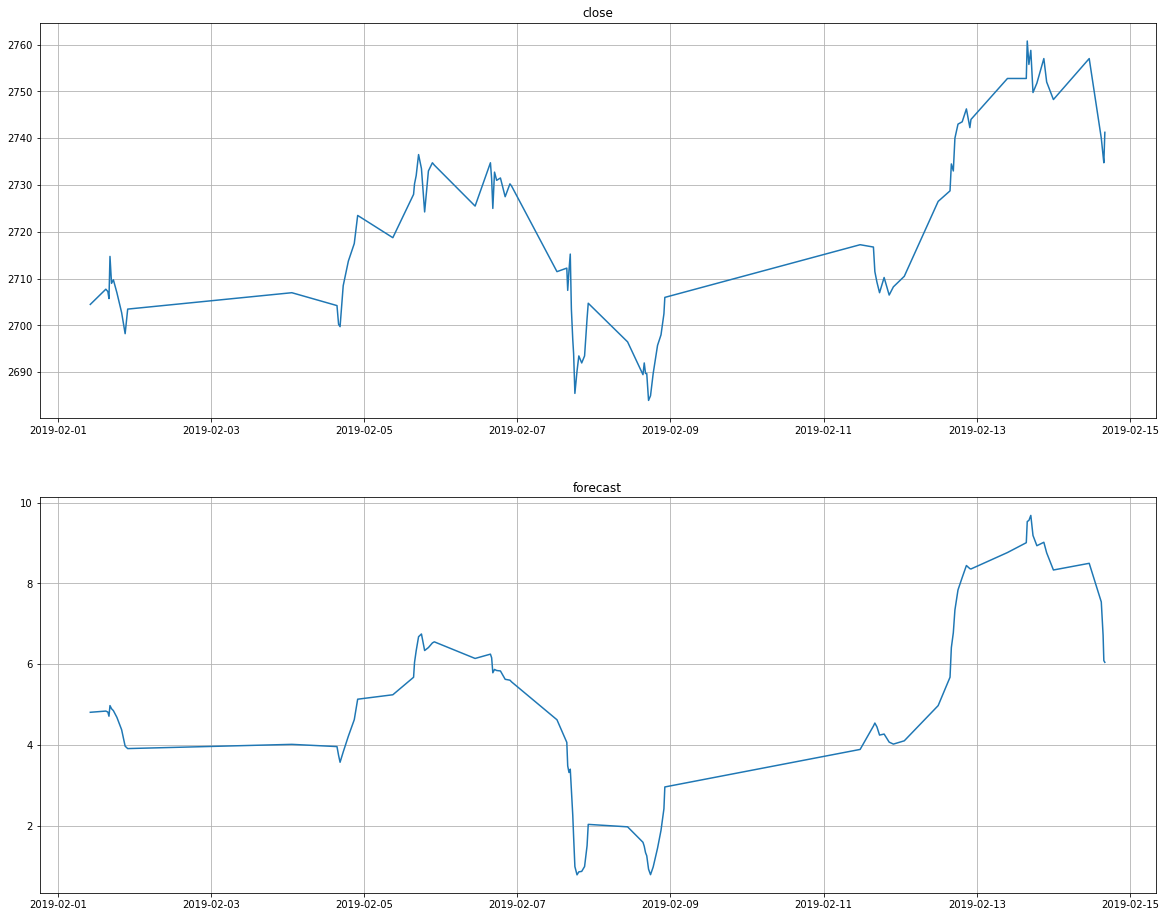

In [13]:
plot(data[['close', 'forecast']].iloc[:100])

In [14]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,-0.0629358,0.0538576,0.0854228,0.0891531,0.0386814,0.0441389,-0.0686492,-0.0524527,-0.0280818
Cumulative returns,-0.0558998,0.0475149,0.0752321,0.0785015,0.0341548,0.0389618,-0.0609954,-0.0465594,-0.0248907
Annual volatility,0.120288,0.105127,0.089527,0.0859756,0.0762336,0.0578783,0.0293605,0.0235245,0.0175114
Sharpe ratio,-0.480311,0.551408,0.960239,1.03624,0.535812,0.77511,-2.40726,-2.27828,-1.61768
Calmar ratio,-0.344716,0.654834,1.37814,1.48727,0.592567,1.18679,-0.99231,-1.01328,-1.1282
Stability,0.66139,0.0064531,0.310153,0.23938,0.000674458,0.325984,0.841318,0.854961,0.76389
Max drawdown,-0.182573,-0.0822462,-0.0619843,-0.0599441,-0.0652776,-0.0371918,-0.0691812,-0.0517654,-0.0248907
Omega ratio,0.920244,1.10253,1.19169,1.22301,1.10748,1.1926,0.432133,0.263181,0
Sortino ratio,-0.633094,0.77782,1.4493,1.5498,0.784625,1.1876,-2.66246,-2.38714,-1.61293
Skew,-0.407595,-0.19181,0.280093,0.170033,0.0432527,0.338519,-3.26149,-6.19959,-13.0737


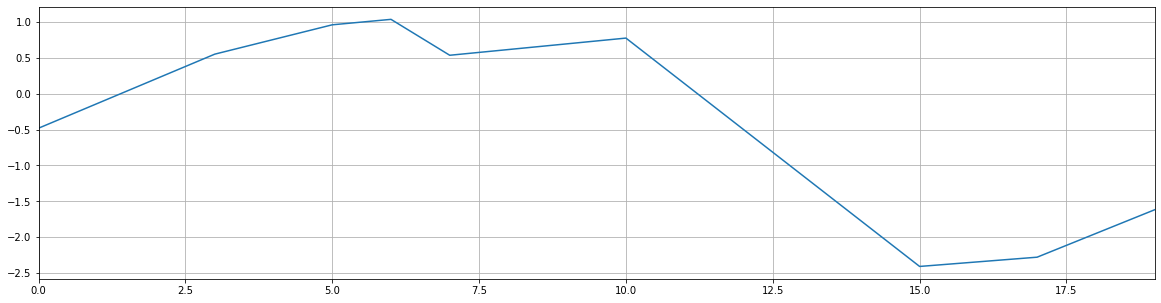

In [15]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [16]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.893157,0.811519,0.729348,0.649636,0.541952,0.067765,-0.008296,0.017413
3,0.893157,1.000000,0.924647,0.822471,0.752114,0.607153,0.097732,0.000507,0.027023
5,0.811519,0.924647,1.000000,0.917606,0.861294,0.699187,0.107773,0.003435,0.033749
6,0.729348,0.822471,0.917606,1.000000,0.932378,0.749351,0.136920,0.042150,0.086752
7,0.649636,0.752114,0.861294,0.932378,1.000000,0.790451,0.173207,0.064623,0.124432
10,0.541952,0.607153,0.699187,0.749351,0.790451,1.000000,0.252803,0.130303,0.224197
15,0.067765,0.097732,0.107773,0.136920,0.173207,0.252803,1.000000,0.731500,0.583877
17,-0.008296,0.000507,0.003435,0.042150,0.064623,0.130303,0.731500,1.000000,0.738838
19,0.017413,0.027023,0.033749,0.086752,0.124432,0.224197,0.583877,0.738838,1.000000


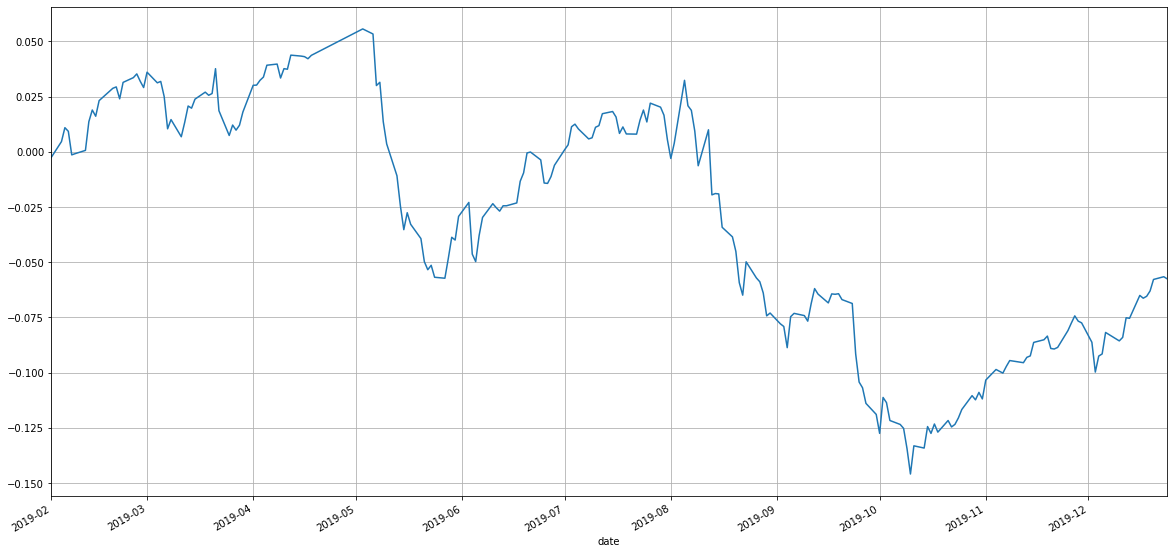

In [17]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

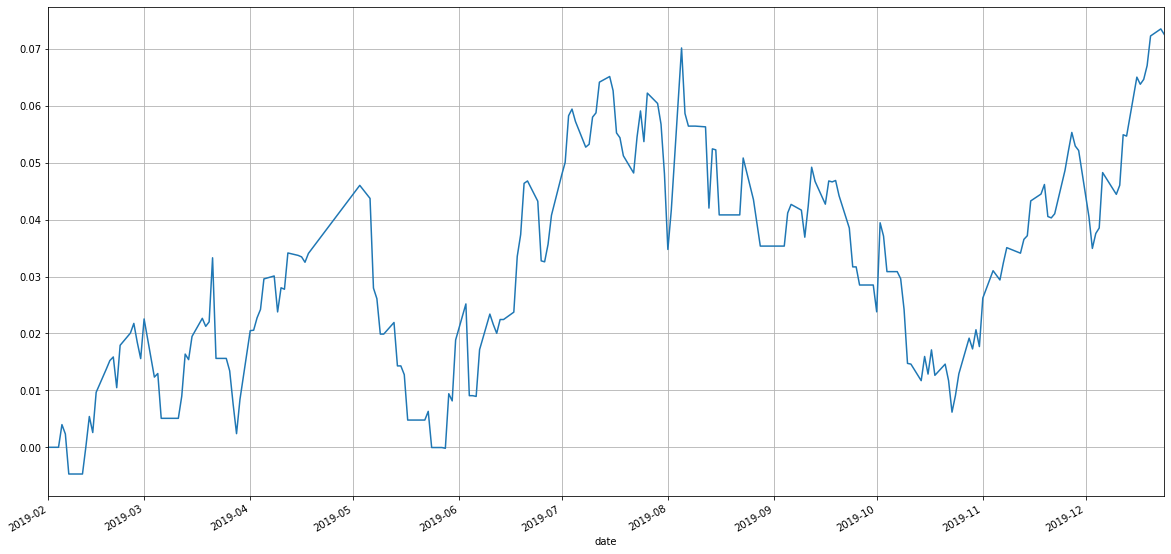

In [18]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

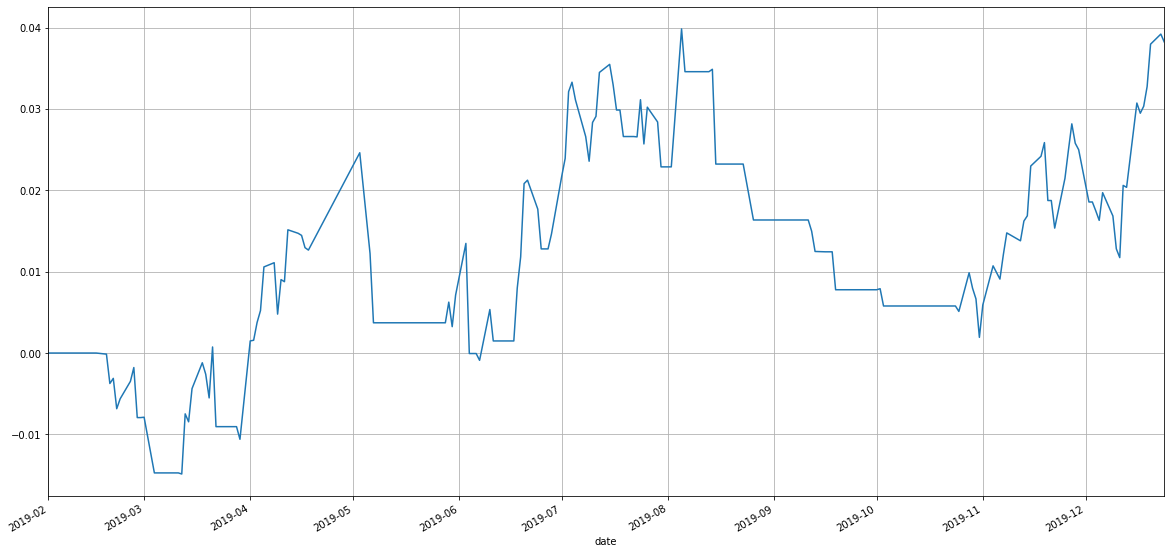

In [19]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);